# Using SQL to turn all the buses around

I have a small hobby project over at [kollektivkart.arktekk.no](https://kollektivkart.arktekk.no/) that is for visualizing changes in public transit in Norway. For some time I've been wanting to do some visualizations on public transit lines. For example, plot the mean delay at each stop used by a line over time.

When trying to do some concept work on this, I discovered a puzzle in the data! Many lines go in two opposite directions. Here in Trondheim, Line 3 goes from Loholt to Hallset, but also from Hallset to Loholt. The way I can tell these apart is to look up the _direction_ in the data. Within a line, there can be variations in each direction. Some services might skip some stops, or depending on how you look at it, others visit extra stops. But these are variations on a theme, and it probably makes sense to group them together to preserve our sanity and not get 12 different plots for each line—2 should be plenty!

There's just one problem! The _direction_ information in the data is not stable over time. What was one day the "Inbound" direction, can suddenly become the "Outbound" direction! That's to say, Hallset to Loholt might be Line 3 Outbound one day, then Inbound Line 3 the next. Oh no!

I didn't just happen to _know_ that, by the way. I made the discovery when my plots weren't making any sense. It turns out that I had assumed that this information would be stable over time, and I didn't check the assumption. It's always good to write down your assumptions and verify them when working with data analysis! Saves you from having to backtrack after having done tons of confusing work.

Anyway, we have a problem in our data and want to check if we can face all the buses in the right direction again using SQL. I've done some setup and made the data public, so you can join in and try playing with the queries yourself. Maybe you'll find a problem, bug or a better solution! Would love to hear from you at the [repository](https://github.com/kaaveland/bus-eta) if you do!

Some setup is necessary. This is a jupyter notebook that is available [here](https://github.com/kaaveland/bus-eta/blob/main/notebooks/LinesEDA.ipynb). It should run just fine if you install jupyter, duckdb, pyarrow and seaborn. You could use [uv](https://docs.astral.sh/uv/). You should get everything you need with this command:

```shell
uv run --with jupyter --with duckdb --with seaborn --with jupysql jupyter lab
```

We'll be using data from [Entur](https://data.entur.no/domain/public-transport-data). This contains data for many years for all bus lanes in the Trondheim region (and many others). I've got a copy of this data going back to 2023 on my machine. But that's a lot more than we need for this exercise, so I've done some preparation and made a smaller download we can use. I've collected the ATB data for 2024 on [this address](https://kaaveland-bus-eta-data.hel1.your-objectstorage.com/atb_legs.parquet) (~900MB download).

I've done a bunch of cleanups on this data, like removing all the buses that were travelling exceedingly close to the speed of light. I've also connected each stop registration in the bus journey with the following stop registration, so we can look at driving durations on individual legs. The [code](https://github.com/kaaveland/bus-eta/blob/main/kollektivkart/etl/legs.py) for that is open source.

We'll be using [jupysql](https://jupysql.ploomber.io/en/latest/quick-start.html) within this notebook, allowing us to use `%sql` in front of a line to send it to DuckDB, or `%%sql` to send an entire cell to DuckDB. We'll do some plots with [seaborn](https://seaborn.pydata.org/). Let's load some data and get started!

In [1]:
import duckdb
import seaborn as sns
# Set up some styling for the visual stuff
sns.set_theme(
    style='whitegrid', rc={
        'figure.figsize': (12, 8),
        'figure.frameon': False,
        'legend.frameon': False
    }
)

db = duckdb.connect(':memory:')
dataset_url = "https://kaaveland-bus-eta-data.hel1.your-objectstorage.com/atb_legs.parquet"

%load_ext sql
%config SqlMagic.displaylimit=50
%sql db --alias duckdb
%sql set memory_limit='16GB';
%sql set threads=8;
%sql create or replace table legs as from read_parquet('{{ dataset_url }}')

The 'toml' package isn't installed. To load settings from pyproject.toml or ~/.jupysql/config, install with: pip install toml

Running query in 'duckdb'

Running query in 'duckdb'

Running query in 'duckdb'

Count
36214722


We gote some 36 million rows in memory now. Let's start by looking at the schema we have:

In [2]:
%sql describe legs;

Running query in 'duckdb'

column_name,column_type,null,key,default,extra
lineRef,VARCHAR,YES,None,None,None
dataSource,VARCHAR,YES,None,None,None
directionRef,VARCHAR,YES,None,None,None
serviceJourneyId,VARCHAR,YES,None,None,None
sequenceNr,BIGINT,YES,None,None,None
start_time,TIMESTAMP WITH TIME ZONE,YES,None,None,None
actual_duration,INTEGER,YES,None,None,None
planned_duration,INTEGER,YES,None,None,None
delay,INTEGER,YES,None,None,None
deviation,INTEGER,YES,None,None,None


For now, these are the most interesting columns for us to focus on:

- `lineRef` is an identifier for a line.
- `directionRef` indicates which direction that this particular journey travels in.
- `serviceJourneyId` is an ID of a trip. With `operatingDate`, it uniquely identifies a journey.
- `sequenceNr` is a monotonically increasing number that increases at each stop point in the journey. Ours starts at `2`, because we use the `sequenceNr` for the `to_stop` of a leg.
- `from_stop` and `to_stop` are two subsequent stop points in a journey.

In theory, we can use `lineRef` and `directionRef` to identify the route of the journey. But I've been claiming that there's a problem with `directionRef`.

## Houston, what exactly is the problem?

I mentioned that I got some unexpected results when analyzing lines. I did a little bit of digging, and identified that the _meaning_ of `directionRef` is not stable over time. Let's take a look at what that means. The `lineRef` where I first identified this problem is `'ATB:Line:2_3'`, one of the lines that I frequently use to/from town. This should have 2 different directions. Let's check:

In [3]:
%%sql
from legs
select count(*) as count, directionRef
where lineRef = 'ATB:Line:2_3'
group by directionRef
order by count desc;

Running query in 'duckdb'

count,directionRef
694901,Inbound
694815,Outbound


At first glance, this looks fine. The data is about evenly distributed, as we'd expect. To illustrate the problem, let's look at a leg on this line. Line 3 goes from Nidarosdomen to Studentersamfundet heading one way, and from Studentersamfundet to Nidarosdomen heading in the opposite direction. Let's check which direction is which:

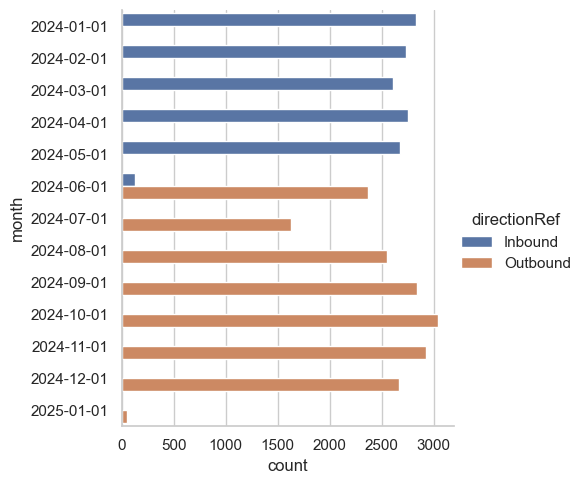

In [4]:
df = db.sql("""
from legs
select count(*) as count, directionRef, date_trunc('month', operatingDate) as month
where
  -- This selects for a single directionRef, right? Right?
  from_stop = 'Studentersamfundet' and to_stop = 'Nidarosdomen'
  and lineRef = 'ATB:Line:2_3'
group by all
order by month;
""").df()

sns.catplot(df, y='month', x='count', hue='directionRef', kind='bar');

Did you see that? They just turned the directions around! It's easy to miss this kind of thing, but it happens all the time. Gathering data from the physical world is complex and difficult!

If we aggregate based on this, the meaning changes some time in the start of summer 2024. Using this for aggregations won't make much sense. It'll be like aggregating the phone book. We'll get numbers, but will anyone pick up?

So, we need to find a way to fix this. Let's zoom in a little bit on June 2024:

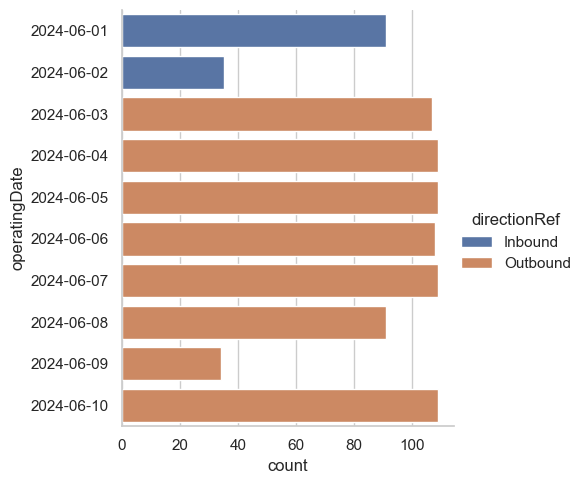

In [5]:
df = db.sql("""
from legs
select count(*) as count, directionRef, operatingDate
-- For me, this is _to_ town
where
  from_stop = 'Studentersamfundet'
  and to_stop = 'Nidarosdomen'
  and lineRef = 'ATB:Line:2_3'
  and operatingDate between '2024-06-01' and '2024-06-10'
group by all
order by operatingDate;
""").df()

sns.catplot(df, y='operatingDate', x='count', hue='directionRef', kind='bar');

We can probably assume that `directionRef` is consistent within one day. This means that if we could build a mapping from `lineRef, operatingDate` to some "canonical" direction, we can handle this issue. That's great news! Building that mapping is the topic of this analysis.

## A canonical what?

Since the meaning of `Inbound` can change, we need some other way to name the direction. My intuition is that we can probably use the most common origin and the most common destination with that `directionRef` on that day. Hopefully, that stays stable across time. I guess we'll find out!

We can easily use window functions to find the first and last stop of each `serviceJourneyId, operatingDate` pair. The way this works is that we define a window, which has two parts:

- A partition, or group key. The window function gets to look at every row within the same partition and do some sort of aggregation.
- We can also use a clause to bound the size of the window, and give it an ordering.

Window functions are awesome! We get to do aggregations without having to throw away lots of rows, saving us lots of subqueries.

Let's do a small demo. First, let's show all the data from one bus journey on line 3:

In [6]:
%%sql
with choice as (
    from legs
    select operatingDate, serviceJourneyId
    where lineRef = 'ATB:Line:2_3' and operatingDate = '2024-01-01'
    limit 1
)
from choice join legs using(operatingDate, serviceJourneyId)
select directionRef, sequenceNr, start_time, from_stop, to_stop
order by sequenceNr;

Running query in 'duckdb'

directionRef,sequenceNr,start_time,from_stop,to_stop
Inbound,2,2024-01-01 15:48:26+01:00,Dragvoll,Edvard Bulls veg
Inbound,3,2024-01-01 15:49:19+01:00,Edvard Bulls veg,Bergheim
Inbound,4,2024-01-01 15:50:37+01:00,Bergheim,Voll studentby
Inbound,5,2024-01-01 15:53:49+01:00,Voll studentby,Moholt studentby
Inbound,6,2024-01-01 15:55:11+01:00,Moholt studentby,Østre Berg
Inbound,7,2024-01-01 15:56:17+01:00,Østre Berg,Berg studentby
Inbound,8,2024-01-01 15:58:10+01:00,Berg studentby,Gløshaugen
Inbound,9,2024-01-01 15:59:57+01:00,Gløshaugen,Høgskoleringen
Inbound,10,2024-01-01 16:01:18+01:00,Høgskoleringen,Studentersamfundet
Inbound,11,2024-01-01 16:02:38+01:00,Studentersamfundet,Nidarosdomen


We can tell that the origin is Dragvoll and the destination is Hallset. We can easily put that information on each row using a window function. Look ma, no `group by`!

In [7]:
%%sql
with choice as (
    from legs
    select operatingDate, serviceJourneyId
    where lineRef = 'ATB:Line:2_3' and operatingDate = '2024-01-01'
    limit 1
)
from choice join legs using(operatingDate, serviceJourneyId)
select
  -- this is old
  directionRef, sequenceNr, start_time, from_stop, to_stop,
  -- new column, window function!
  min_by(from_stop, sequenceNr) over (
    partition by (operatingDate, serviceJourneyId)
  ) as origin,
  -- also a window function
  max_by(to_stop, sequenceNr) over (
    partition by (operatingDate, serviceJourneyId)
  ) as destination
order by sequenceNr;

Running query in 'duckdb'

directionRef,sequenceNr,start_time,from_stop,to_stop,origin,destination
Inbound,2,2024-01-01 15:48:26+01:00,Dragvoll,Edvard Bulls veg,Dragvoll,Hallset
Inbound,3,2024-01-01 15:49:19+01:00,Edvard Bulls veg,Bergheim,Dragvoll,Hallset
Inbound,4,2024-01-01 15:50:37+01:00,Bergheim,Voll studentby,Dragvoll,Hallset
Inbound,5,2024-01-01 15:53:49+01:00,Voll studentby,Moholt studentby,Dragvoll,Hallset
Inbound,6,2024-01-01 15:55:11+01:00,Moholt studentby,Østre Berg,Dragvoll,Hallset
Inbound,7,2024-01-01 15:56:17+01:00,Østre Berg,Berg studentby,Dragvoll,Hallset
Inbound,8,2024-01-01 15:58:10+01:00,Berg studentby,Gløshaugen,Dragvoll,Hallset
Inbound,9,2024-01-01 15:59:57+01:00,Gløshaugen,Høgskoleringen,Dragvoll,Hallset
Inbound,10,2024-01-01 16:01:18+01:00,Høgskoleringen,Studentersamfundet,Dragvoll,Hallset
Inbound,11,2024-01-01 16:02:38+01:00,Studentersamfundet,Nidarosdomen,Dragvoll,Hallset


So that's pretty neat!

We don't really need window functions for this, we can do this with `group by`. But knowing about window functions will come in handy later!

In DuckDB, we have a `qualify` clause that we can put after `where`, which allows us to filter a row based on a window function. We can't use `where` to filter on the result of a window function, because `where` is necessary in order find out which rows that are part of the window! Many SQL dialects now support `qualify`, which is a super handy quality of life change. Without it, we would need to use a subquery or CTE.

Let's make a table that maps from `operatingDate, lineRef, directionRef` to the most commonly used `origin` and `destination` pair for that combination.

In [8]:
%%sql
create or replace table route_name as
with counts as (
  from legs
  select
    -- This is the triple we want to name / map
    operatingDate,
    lineRef,
    directionRef,
    -- These are what we'll use for naming. Maybe they're stable over time?
    min_by(from_stop, sequenceNr) as origin,
    max_by(to_stop, sequenceNr) as destination,
    -- We'll use this to rank them, picking the most common pair of origin/destination
    -- as the name for the `directionRef` on this day
    count(*) as count
  group by all -- handy shortcut to group by whatever we didn't aggregate
)
from counts
select
  operatingDate,
  lineRef,
  directionRef,
  origin,
  destination,
  count
qualify
  count = max(count) over (partition by (operatingDate, lineRef, directionRef));

Running query in 'duckdb'

Count
149176


Let's zoom in on June 2024 again, and check if this fixes our problem:

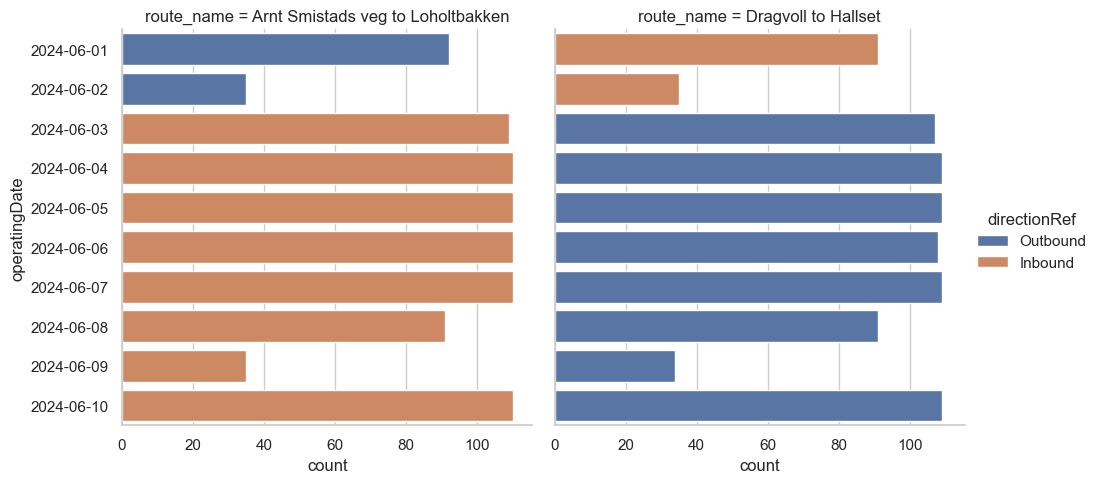

In [9]:
df = db.sql("""
from legs join route_name using(operatingDate, directionRef, lineRef)
select count(*) as count, directionRef, operatingDate, origin || ' to ' || destination as route_name
where
  ((from_stop = 'Studentersamfundet' and to_stop = 'Nidarosdomen') or (from_stop = 'Nidarosdomen' and to_stop = 'Studentersamfundet'))
  and (lineRef = 'ATB:Line:2_3' and operatingDate between '2024-06-01' and '2024-06-10')
group by all
order by operatingDate;
""").df()

sns.catplot(df, y='operatingDate', x='count', hue='directionRef', col='route_name', kind='bar');

## Huge success!

These stay stable even when the meaning of `directionRef` changes. Now let's zoom back out:

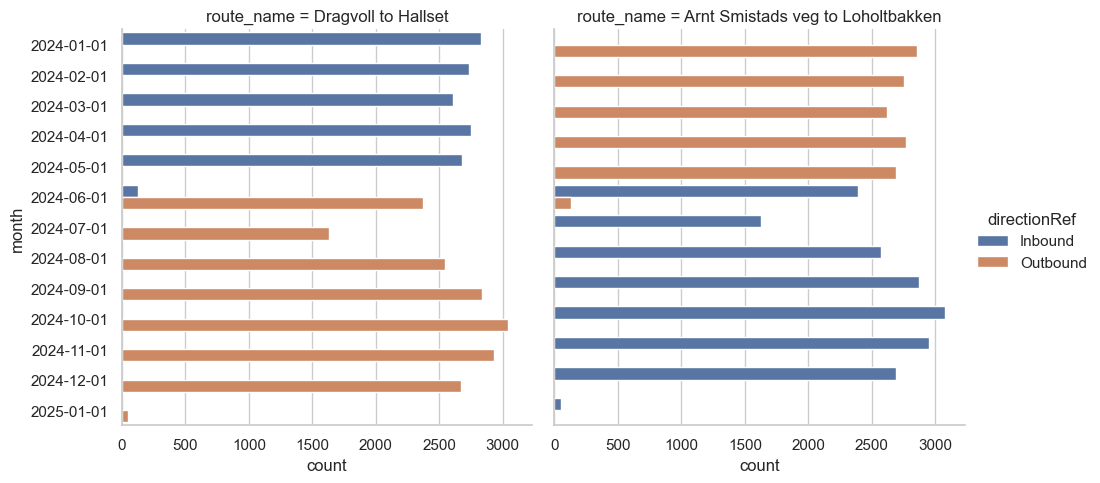

In [10]:
df = db.sql("""
from legs join route_name using(operatingDate, directionRef, lineRef)
select count(*) as count, directionRef, date_trunc('month', operatingDate) as month, origin || ' to ' || destination as route_name
where
  ((from_stop = 'Studentersamfundet' and to_stop = 'Nidarosdomen') or (from_stop = 'Nidarosdomen' and to_stop = 'Studentersamfundet'))
  and (lineRef = 'ATB:Line:2_3')
group by all
order by month;
""").df()

sns.catplot(df, y='month', x='count', hue='directionRef', col='route_name', kind='bar');

This appears to be stable all year. Great news! We're not entirely home-free, though.

Let me show you what I mean by sampling another lineRef:

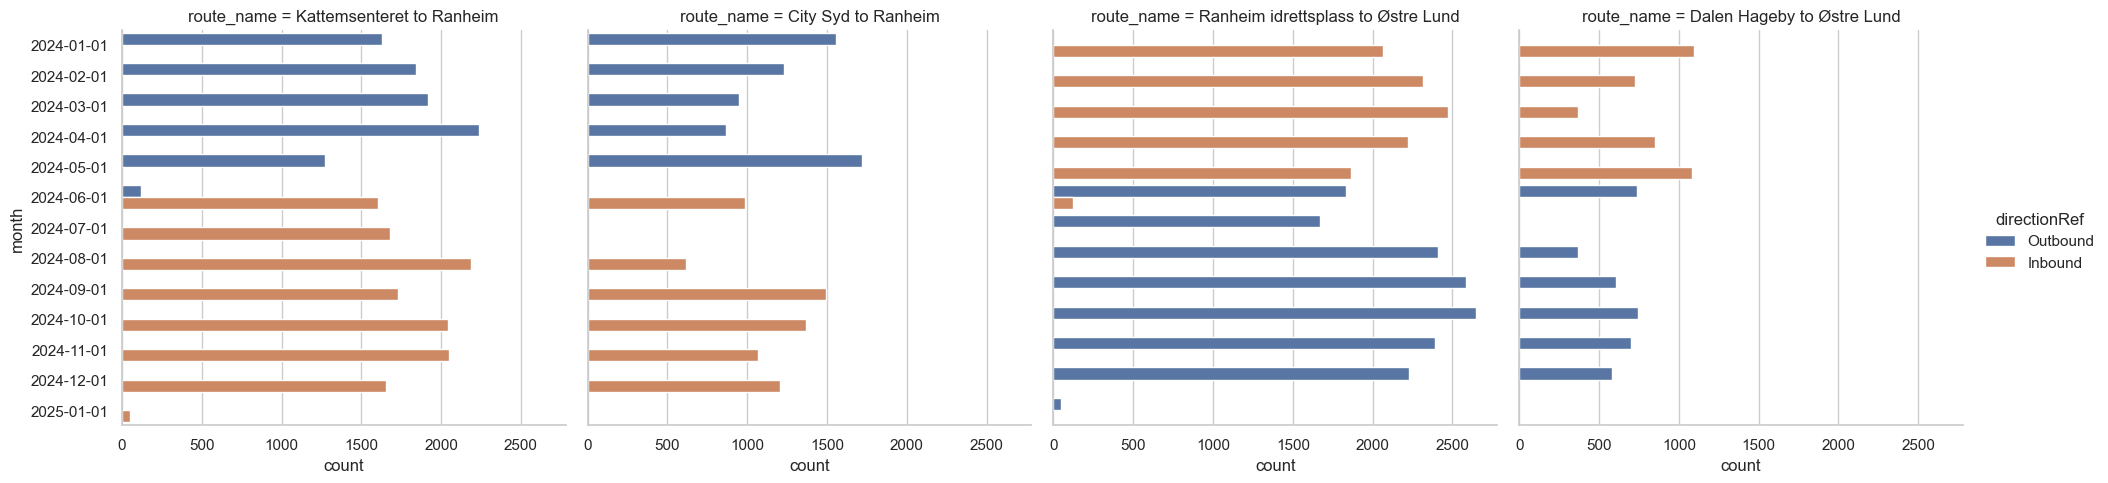

In [11]:
df = db.sql("""
from legs join route_name using(operatingDate, directionRef, lineRef)
select count(*) as count, directionRef, date_trunc('month', operatingDate) as month, origin || ' to ' || destination as route_name
where
  ((from_stop = 'Studentersamfundet' and to_stop = 'Nidarosdomen') or (from_stop = 'Nidarosdomen' and to_stop = 'Studentersamfundet'))
  and (lineRef = 'ATB:Line:2_1')
group by all
order by month;
""").df()

sns.catplot(df, y='month', x='count', hue='directionRef', col='route_name', kind='bar');

## Huge disappointment!

Oh no, this one has more variations!

Fortunately, we can fix this too! Perhaps not perfectly, but something that should be close enough.

What should be sufficient is to set a permanent _directionRef_ for each route name. We'll use the first directionRef we ever observed for that route. This is just a minor tweak to our `route_name` table from above:

In [12]:
%%sql
create or replace table route_name as
with counts as (
  from legs
  select
    operatingDate,
    lineRef,
    directionRef,
    min_by(from_stop, sequenceNr) as origin,
    max_by(to_stop, sequenceNr) as destination,
    count(*) as count
  group by all
)
from counts
select
  operatingDate,
  lineRef,
  directionRef,
  -- Changed this! We'll propagate the first directionRef seen for this line/origin/destination
  -- to all of eternity
  min_by(directionRef, operatingDate) over (partition by (lineRef, origin, destination)) as canonical_direction,
  origin,
  destination,
  count
qualify
  count = max(count) over (partition by (operatingDate, lineRef, directionRef))

Running query in 'duckdb'

Count
149176


## Did we conquer line 1 now?

Let's check whether we can use the new `canonical_direction` to separate these now:

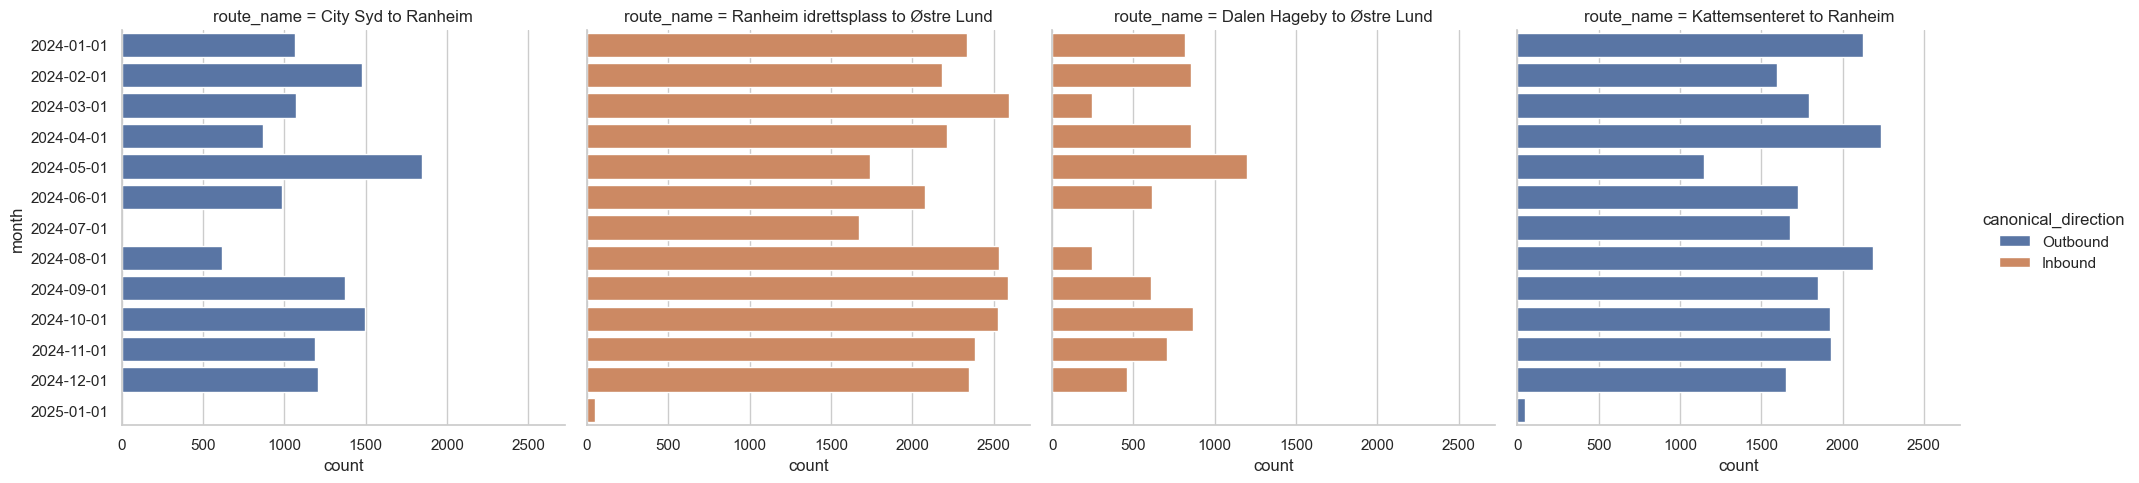

In [13]:
df = db.sql("""
from legs join route_name using(operatingDate, directionRef, lineRef)
select count(*) as count, date_trunc('month', operatingDate) as month, canonical_direction, origin || ' to ' || destination as route_name
where
  ((from_stop = 'Studentersamfundet' and to_stop = 'Nidarosdomen') or (from_stop = 'Nidarosdomen' and to_stop = 'Studentersamfundet'))
  and (lineRef = 'ATB:Line:2_1')
group by all
order by month;
""").df()

sns.catplot(df, y='month', x='count', hue='canonical_direction', col='route_name', kind='bar');

## Looks pretty good!

This seems to fix our main problem. This notebook wouldn't be complete without taking a look at what kind of difference this makes, though. Let's do some shallow plotting so we can compare the mean delay at the latest stop in each journey by `directionRef`, and by `canonical_direction`.

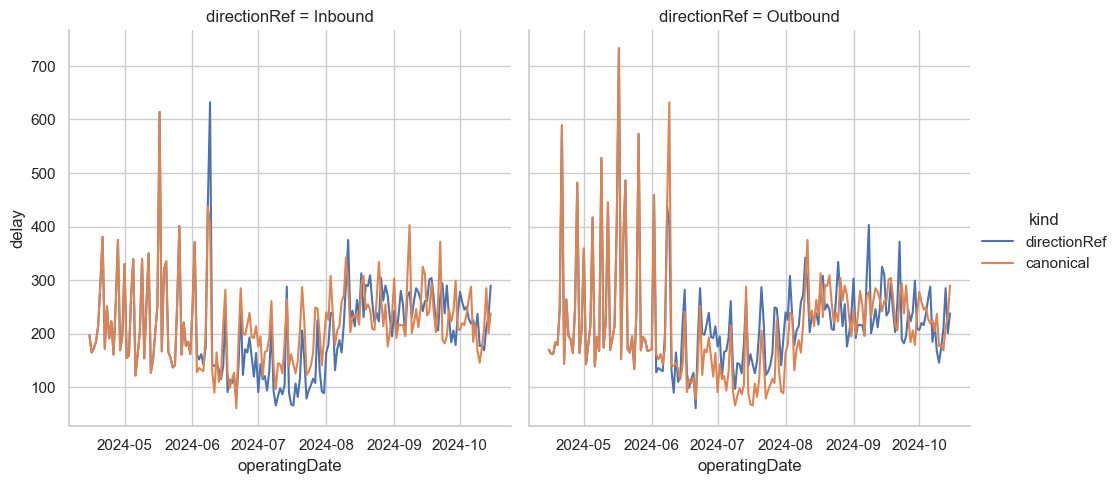

In [14]:
df = db.sql("""
with journey_delay as (
    from legs
    select
        operatingDate,
        serviceJourneyId,
        directionRef,
        lineRef,
        max_by(delay, sequenceNr) as delay
    where operatingDate between '2024-04-15' and '2024-10-15'
    group by all
), regular as (
    select
        operatingDate,
        quantile_disc(delay, .75) as delay,
        directionRef,
        'directionRef' as kind
    from journey_delay
    where lineRef = 'ATB:Line:2_3'
    group by all
    order by operatingDate, directionRef
), canonical as (
    select
        operatingDate,
        quantile_disc(delay, .75) as delay,
        route_name.canonical_direction as directionRef,
        'canonical' as kind
    from journey_delay join route_name using(operatingDate, lineRef, directionRef)
    where lineRef = 'ATB:Line:2_3'
    group by all
    order by operatingDate, directionRef
)
select * from regular
union all
select * from canonical
""").df()

sns.relplot(
    df, x='operatingDate', y='delay', hue='kind',  col='directionRef', kind='line'
);

Makes a difference! I'll make a job that keeps something like the `route_name` table up to date so that I can keep track of the "true" direction of a line for my analysis. Should be fun to see if this works with all ~500 million legs in the main data set!

Thanks for reading!